In [1]:
## Multi class classification with Linear SVC

In [1]:
import pandas as pd
import numpy as np
import scipy
from nltk.corpus import stopwords
import re
import os

In [2]:
## Loading Data - labelled data :

data_1 = pd.ExcelFile('R2_RNN_Tranzact_Rohan_1_Regrouped_with_supplier.xlsx')
tranzact_data_1 = data_1.parse(0)

## Loading Data - un-labelled data:

data_2 = pd.ExcelFile('14Mar_Gorky_one_labelled.xlsx')
tranzact_data_new_1 = data_2.parse(0)


In [22]:
tranzact_data_new_1.tail()

,buyer_item_id,buyer_itemid,buyer_item_name,product,from_company_id,from_company_name,to_company_id,to_company_name
17746,289052,PLYBAG_10X15,POLYBAG_10X15 INCH_PP,PACKAGING,13872,R-Tech Products & Packaging Pvt Ltd,16730,GLORY PACK INDUSTRIES
17747,289639,HANDLENUTM12X5MMXX,"HANDLE NUT 1"" #600,HTB,A194 Gr8",NaN,842,CESARE BONETTI INDIA PVT. LTD.,7434,Shah Brothers
17748,48512,RDBR50 (SS431),ROUND BAR OD50 ASTM A276 TYPE 431,NaN,114,Entech Controls,921,ALPESH METALS
17749,57696,PGX618101601202200,"PTV 6"" #300 RF BVE WCB HW IBR",NaN,7506,CESARE BONETTI INTERNATIONAL PVT. LTD.,842,CESARE BONETTI INDIA PVT. LTD.
17750,274954,PPBOX_ST5,PP_MONOBOX_ST5,PACKAGING,13872,R-Tech Products & Packaging Pvt Ltd,15527,Shree Arun Packaging Co. Pvt. Ltd.


In [34]:
## Picking up required info from labelled data :

col = ['to_company_name', 'supplier_item_id.2', 'product', 'supplier']
tranzact_data_2 = tranzact_data_1[col]
tranzact_data_2.columns = ['OEM', 'item', 'product', 'supplier']

## Picking up required info from un-labelled data:

col = ['from_company_name', 'buyer_item_name', 'product', 'to_company_name']
tranzact_data_new_2 = tranzact_data_new_1[col]
tranzact_data_new_2.columns = ['OEM', 'item', 'product', 'supplier']

# Creating separate dataframe for Cesare Bonetti International Pvt. Ltd. from labelled Dat:

tranzact_data_cesare_international_1 = tranzact_data_2.loc[tranzact_data_2['OEM'] \
                                                               == 'CESARE BONETTI INTERNATIONAL PVT. LTD.']
tranzact_data_2_revised = tranzact_data_2.drop(tranzact_data_cesare_international_1.index)
tranzact_data_cesare_international_1 = tranzact_data_cesare_international_1.reset_index(drop=True)
tranzact_data_2_revised = tranzact_data_2_revised.reset_index(drop=True)

# Creating separate dataframe for Cesare Bonetti International Pvt. Ltd. from unlabelled data :

tranzact_data_cesare_international_2 = tranzact_data_new_2.loc[tranzact_data_new_2['OEM'] \
                                                               == 'CESARE BONETTI INTERNATIONAL PVT. LTD.']
tranzact_data_new_2_revised = tranzact_data_new_2.drop(tranzact_data_cesare_international_2.index)
tranzact_data_cesare_international_2 = tranzact_data_cesare_international_2.reset_index(drop=True)
tranzact_data_new_2_revised = tranzact_data_new_2_revised.reset_index(drop=True)


print('Labelled Data(tranzact_data_2_revised) = ', len(tranzact_data_2_revised))
print('Unlabelled Data(tranzact_data_new_2_revised) = ', len(tranzact_data_new_2_revised))
print('Bonetti International extracted frm labelled data = ', len(tranzact_data_cesare_international_1))
print('Bonetti International extracted frm un-labelled data = ', len(tranzact_data_cesare_international_2))


Labelled Data(tranzact_data_2_revised) =  11803
Unlabelled Data(tranzact_data_new_2_revised) =  11842
Bonetti International extracted frm labelled data =  1754
Bonetti International extracted frm un-labelled data =  5909


In [35]:
# Removing all 'Bonetti' & 'Waaree' supplier from both labelled and un-labelled data :

## First make Items in lower case and remove rows with any cell value = none :

tranzact_data_2_revised['item'] = tranzact_data_2_revised['item'].map(lambda x: x if type(x)!=str else x.lower()) 
tranzact_data_2_revised['product'] = tranzact_data_2_revised['product'].map(lambda x: x if type(x)!=str else x.lower())
tranzact_data_2_revised['supplier'] = tranzact_data_2_revised['supplier'].map(lambda x: x if type(x)!=str else x.lower())
#tranzact_data_2_revised = tranzact_data_2_revised.dropna() ## remove rows with cell value none

tranzact_data_new_2_revised['item'] = tranzact_data_new_2_revised['item'].map(lambda x: x if type(x)!=str else x.lower())
tranzact_data_new_2_revised['product'] = tranzact_data_new_2_revised['product'].map(lambda x: x if type(x)!=str else x.lower())
tranzact_data_new_2_revised['supplier'] = tranzact_data_new_2_revised['supplier'].map(lambda x: x if type(x)!=str else x.lower())
#tranzact_data_new_2_revised = tranzact_data_new_2_revised.dropna() ## remove rows with cell value none

# Removing string 'bonetti' and 'waaree' from supplier :

supplier_bonetti_2 = tranzact_data_2_revised[tranzact_data_2_revised['supplier'].str.contains('bonetti')]
supplier_waaree_2 = tranzact_data_2_revised[tranzact_data_2_revised['supplier'].str.contains('waaree')]
supplier_bonetti_new_2 = tranzact_data_new_2_revised[tranzact_data_new_2_revised['supplier'].str.contains('bonetti')]
supplier_waaree_new_2 = tranzact_data_new_2_revised[tranzact_data_new_2_revised['supplier'].str.contains('waaree')]

tranzact_data_3 = tranzact_data_2_revised.drop(supplier_bonetti_2.index) # 'bonetti' removed
tranzact_data_3 = tranzact_data_3.drop(supplier_waaree_2.index)   # 'waaree' removed
tranzact_data_new_3 = tranzact_data_new_2_revised.drop(supplier_bonetti_new_2.index)
tranzact_data_new_3 = tranzact_data_new_3.drop(supplier_waaree_new_2.index)

tranzact_data_3 = tranzact_data_3.reset_index(drop=True)
tranzact_data_new_3 = tranzact_data_new_3.reset_index(drop=True)

print(len(tranzact_data_3))
print(len(tranzact_data_new_3))

tranzact_data_new_3.head()


10546
11078


,OEM,item,product,supplier
0,Polfrost Air Con Pvt Ltd.,emerson liquid line filter/drier ek-165s (0476...,NaN,h j international
1,Nandan GSE Pvt Ltd,"hydraulic fittings - cramping nipple - 3/8"" x ...",NaN,asiatic hydraulics
2,Nandan GSE Pvt Ltd,hydraulic fitting - hose clip elbow 1/4 x 5/16,NaN,asiatic hydraulics
3,Nandan GSE Pvt Ltd,"hydraulic hose pipe - hose pipe 3/4"" x 500mm",NaN,asiatic hydraulics
4,Nandan GSE Pvt Ltd,"hydraulic hose pipe - hose pipe 3/4"" x 3 mtr 6...",NaN,asiatic hydraulics


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [36]:
# Merging two data frames :

tranzact_data_combined = pd.concat([tranzact_data_3, tranzact_data_new_3], axis=0, ignore_index=True)

# Removing duplicate (item + supplier) combinations :

tranzact_data_combined['find_duplicate'] = tranzact_data_combined['item'].map(str) + \
                                            tranzact_data_combined['supplier'].map(str)

tranzact_data_combined.drop_duplicates(subset='find_duplicate', keep = 'first', inplace = True)
tranzact_data_combined = tranzact_data_combined.reset_index(drop=True)

print(len(tranzact_data_combined))
print(tranzact_data_combined['item'][1])
print(tranzact_data_combined['item'][30])
print(tranzact_data_combined['item'][98])
print(tranzact_data_combined['item'][1988])
print(tranzact_data_combined['item'][20461])

21371
accumulator - model a-as 5126, (3/4" connection) - emerson make
pneumatic actuator rpa330sr-4-s (air fail to open)
shavo make afr, model no. sb07-225-m7ka, size - 1/4" npt, filter element : 15 micron, metal bowl
3 ply 150 gsm cardboard sheet 2-meter x 1-meter
manual override, 1600nm torque, moc: aluminium


In [252]:
tranzact_data_combined.to_excel(r'/home/scar3crow/Downloads/18_04_test_1.xlsx')

In [37]:
## cleaning the data

pd.options.mode.chained_assignment = None

## Join all hyphaned words :

tranzact_data_combined['item'] = tranzact_data_combined['item'].str.replace(r'([a-z])-([a-z])', r'\1\2')
tranzact_data_combined['item'] = tranzact_data_combined['item'].str.replace(r'([0-9])-([a-z])', r'\1\2')

## Removing underscores '_':

punctuation = ['_']

for i in punctuation:
    
    tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(i," ")

tranzact_data_combined['item'] = tranzact_data_combined['item'].str.replace(r'\W',' ')   ## remove puntuations

print(tranzact_data_combined['item'][1])
print(tranzact_data_combined['item'][30])
print(tranzact_data_combined['item'][1988])
print(tranzact_data_combined['item'][194])

accumulator   model aas 5126   3 4  connection    emerson make
pneumatic actuator rpa330sr 4s  air fail to open 
3 ply 150 gsm cardboard sheet 2meter x 1meter
rm sn 515 top  c i  casting fg 150   is 210 1993 


In [254]:
tranzact_data_combined.to_excel(r'/home/scar3crow/Downloads/18_04_test_2.xlsx')

In [38]:
## joinning consecutive single letters - SS:

s_s_list = pd.DataFrame()
s_s_list['item'] = tranzact_data_combined['item'].str.findall(r'(?i)\b[s]\s+\b[s]\b')    
s_s_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'(?i)\b[s]\s+\b[s]\b')].index.values
s_s_list = s_s_list[s_s_list.astype(str)['item'] != '[]']
s_s_list['joined'] = s_s_list.item.apply(''.join)
s_s_list.joined = s_s_list.joined.str.replace(' ', '')

## joinning consecutive single letters - MS:

ms_list = pd.DataFrame()
ms_list['item'] = tranzact_data_combined['item'].str.findall(r'(?i)\b[m]\s+\b[s]\b')    
ms_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'(?i)\b[m]\s+\b[s]\b')].index.values
ms_list = ms_list[ms_list.astype(str)['item'] != '[]']
ms_list['joined'] = ms_list.item.apply(''.join)
ms_list.joined = ms_list.joined.str.replace(' ', '')

## joinning consecutive single letters - CI:

ci_list = pd.DataFrame()
ci_list['item'] = tranzact_data_combined['item'].str.findall(r'(?i)\b[c]\s+\b[i]\b')    
ci_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'(?i)\b[c]\s+\b[i]\b')].index.values
ci_list = ci_list[ci_list.astype(str)['item'] != '[]']
ci_list['joined'] = ci_list.item.apply(''.join)
ci_list.joined = ci_list.joined.str.replace(' ', '')

## joinning consecutive single letters - CS:

cs_list = pd.DataFrame()
cs_list['item'] = tranzact_data_combined['item'].str.findall(r'(?i)\b[c]\s+\b[s]\b')    
cs_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'(?i)\b[c]\s+\b[s]\b')].index.values
cs_list = cs_list[cs_list.astype(str)['item'] != '[]']
cs_list['joined'] = cs_list.item.apply(''.join)
cs_list.joined = cs_list.joined.str.replace(' ', '')


In [39]:
## substituting above cell in tranzact_data_combine :

for i in s_s_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'(?i)\b[s]\s+\b[s]\b', s_s_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]
    
for i in ms_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'(?i)\b[m]\s+\b[s]\b', ms_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]
    
for i in ci_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'(?i)\b[c]\s+\b[i]\b', ci_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]
    
for i in cs_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'(?i)\b[c]\s+\b[s]\b', cs_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]


In [257]:
tranzact_data_combined.to_excel(r'/home/scar3crow/Downloads/18_04_test_3.xlsx')

In [40]:
# making list for joinning is with number(indian standards):
is_list = pd.DataFrame()
is_list['item'] = tranzact_data_combined['item'].str.findall(r'\b\is\s+\d+\b')
is_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\b\is\s+\d+\b')].index.values
is_list = is_list[is_list.astype(str)['item'] != '[]']
is_list['joined'] = is_list.item.apply(''.join)
is_list.joined = is_list.joined.str.replace(' ', '')

# making list for joinning en with number(en standards):
en_list = pd.DataFrame()
en_list['item'] = tranzact_data_combined['item'].str.findall(r'\b\en\s+\d+\b')
en_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\b\en\s+\d+\b')].index.values
en_list = en_list[en_list.astype(str)['item'] != '[]']
en_list['joined'] = en_list.item.apply(''.join)
en_list.joined = en_list.joined.str.replace(' ', '')
2,
# making list for joinning ss with number(ss standards):
ss_list = pd.DataFrame()
ss_list['item'] = tranzact_data_combined['item'].str.findall(r'\bs\w\s+\d{2,3}\b')
ss_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\bs\w\s+\d{2,3}\b')].index.values
ss_list = ss_list[ss_list.astype(str)['item'] != '[]']
ss_list['joined'] = ss_list.item.apply(''.join)
ss_list.joined = ss_list.joined.str.replace(' ', '')

# making list for joinning fg with number(casting standards):
fg_list = pd.DataFrame()
fg_list['item'] = tranzact_data_combined['item'].str.findall(r'\b[f]\g\s+\d+\b')
fg_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\b[f]\g\s+\d+\b')].index.values
fg_list = fg_list[fg_list.astype(str)['item'] != '[]']
fg_list['joined'] = fg_list.item.apply(''.join)
fg_list.joined = fg_list.joined.str.replace(' ', '')


In [41]:
## substituting above cell in tranzact_data_combine :

for i in is_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'\b\is\s+\d+\b', is_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]
    
for i in en_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'\b\en\s+\d+\b', en_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]
    
for i in ss_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'\bs\w\s+\d{2,3}\b', ss_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]
    
for i in fg_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'\b[f]\g\s+\d+\b', fg_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]

In [42]:
## Remove dimensions alongwith units(mm etc) and lastly integers :

tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\b\d+x\d+x\d+\w*\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\b\d+x\d+\w*\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\b\d+\w*\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\bx\w+\b',' ')

tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\b\id\s*\d+\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\b\od\s*\d+\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\bd\ia\s*\d+\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\bd\s*\d+\b',' ')

## Remove m8 etc. :

tranzact_data_combined['item'] = tranzact_data_combined['item'].str.replace(r'\b\m\d+\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\b\m\d+x\w+\b',' ')


## Remove bad words as per list below :
, 
bad_ist = ['mm', 'inch', 'ft', 'feet', 'mtr', 'volt', 'amp', 'micron', 'microns', 'swg', 'cfm', 'kg', \
           'tons', 'mfd', 'ah', 'id', 'od', 'dia', 'to', 'for', 'x']

tranzact_data_combined['item']= tranzact_data_combined['item'].apply(lambda x:' '.join([i for i in x.split()
                                                                                if i not in bad_ist]).lower())



tranzact_data_combined = tranzact_data_combined.reset_index(drop=True)

In [35]:

print(tranzact_data_combined['item'][10546+353])
print(tranzact_data_combined['item'][10546+604])
print(tranzact_data_combined['item'][10546+1594])

round bar is2062 e250 a
hand wheel cast ggv a536
pinion seal l12 teflon


In [261]:
tranzact_data_combined.to_excel(r'/home/scar3crow/Downloads/17_04_test_3.xlsx')

In [43]:
# Splitting data into labelled and unlabelled :

tranzact_data_labelled = pd.DataFrame()
tranzact_data_unlabelled = pd.DataFrame()

tranzact_data_labelled = tranzact_data_combined[tranzact_data_combined['product'].notnull()]
tranzact_data_labelled = tranzact_data_labelled.dropna() ## remove any other rows with cell value none
tranzact_data_unlabelled = tranzact_data_combined.drop(tranzact_data_labelled.index)


tranzact_data_labelled = tranzact_data_labelled.reset_index(drop=True)
tranzact_data_unlabelled = tranzact_data_unlabelled.reset_index(drop=True)

In [39]:
tranzact_data_labelled.tail()

,OEM,item,product,supplier,find_duplicate
10871,R-Tech Products & Packaging Pvt Ltd,fc pouch,packaging,lucky enterprise,fc pouch 50lucky enterprise
10872,R-Tech Products & Packaging Pvt Ltd,connector filter,misc,wonder pen tips (p) ltd.,connector filterwonder pen tips (p) ltd.
10873,R-Tech Products & Packaging Pvt Ltd,polybag pp,packaging,glory pack industries,polybag 9x13 inch_ppglory pack industries
10874,R-Tech Products & Packaging Pvt Ltd,polybag pp,packaging,glory pack industries,polybag_10x15 inch_ppglory pack industries
10875,R-Tech Products & Packaging Pvt Ltd,pp monobox st5,packaging,shree arun packaging co. pvt. ltd.,pp_monobox_st5shree arun packaging co. pvt. ltd.


In [40]:
tranzact_data_unlabelled.tail()

,OEM,item,product,supplier,find_duplicate
10490,CESARE BONETTI INDIA PVT. LTD.,inside caliper size,NaN,ankit marketing pvt. ltd.,inside caliper size 12''ankit marketing pvt. ltd.
10491,CESARE BONETTI INDIA PVT. LTD.,ms wire brush diameter,NaN,damodar enterprises,ms wire brush diameter 24mm x 6mmdamodar enter...
10492,CESARE BONETTI INDIA PVT. LTD.,ms wire brush diameter,NaN,damodar enterprises,ms wire brush diameter 12mm x 6mmdamodar enter...
10493,CESARE BONETTI INDIA PVT. LTD.,handle nut htb a194 gr8,NaN,shah brothers,"handle nut 1"" #600,htb,a194 gr8shah brothers"
10494,Entech Controls,round bar astm a276 type,NaN,alpesh metals,round bar od50 astm a276 type 431alpesh metals


In [44]:
# digitising 'product' and creating a dictionary :

tranzact_data_labelled['product_id'] = tranzact_data_labelled['product'].factorize()[0]

product_id_df = tranzact_data_labelled[['product', 'product_id']].drop_duplicates().sort_values('product_id')
product_to_id = dict(product_id_df.values)
id_to_product = dict(product_id_df[['product_id', 'product']].values)

tranzact_data_labelled.head()

,OEM,item,product,supplier,find_duplicate,product_id
0,Polfrost Air Con Pvt Ltd.,new cylinder gas,gas,stallion enterprises,new cylinder 404 gasstallion enterprises,0
1,Ecofrost Technologies Private Limited,accumulator model aas connection emerson make,cooling,neelam enterprises,"accumulator - model a-as 5126, (3/4"" connectio...",1
2,Ecofrost Technologies Private Limited,accumulator flokool psi fksa596,cooling,t j controls,"accumulator; flokool; 3/4""; 400 psi, fksa596t ...",1
3,Polfrost Air Con Pvt Ltd.,accumulator connection,cooling,h j international,accumulator 1.5/8 connectionh j international,1
4,Polfrost Air Con Pvt Ltd.,accumulator,cooling,h j international,accumulator 7/8‘’h j international,1


1379


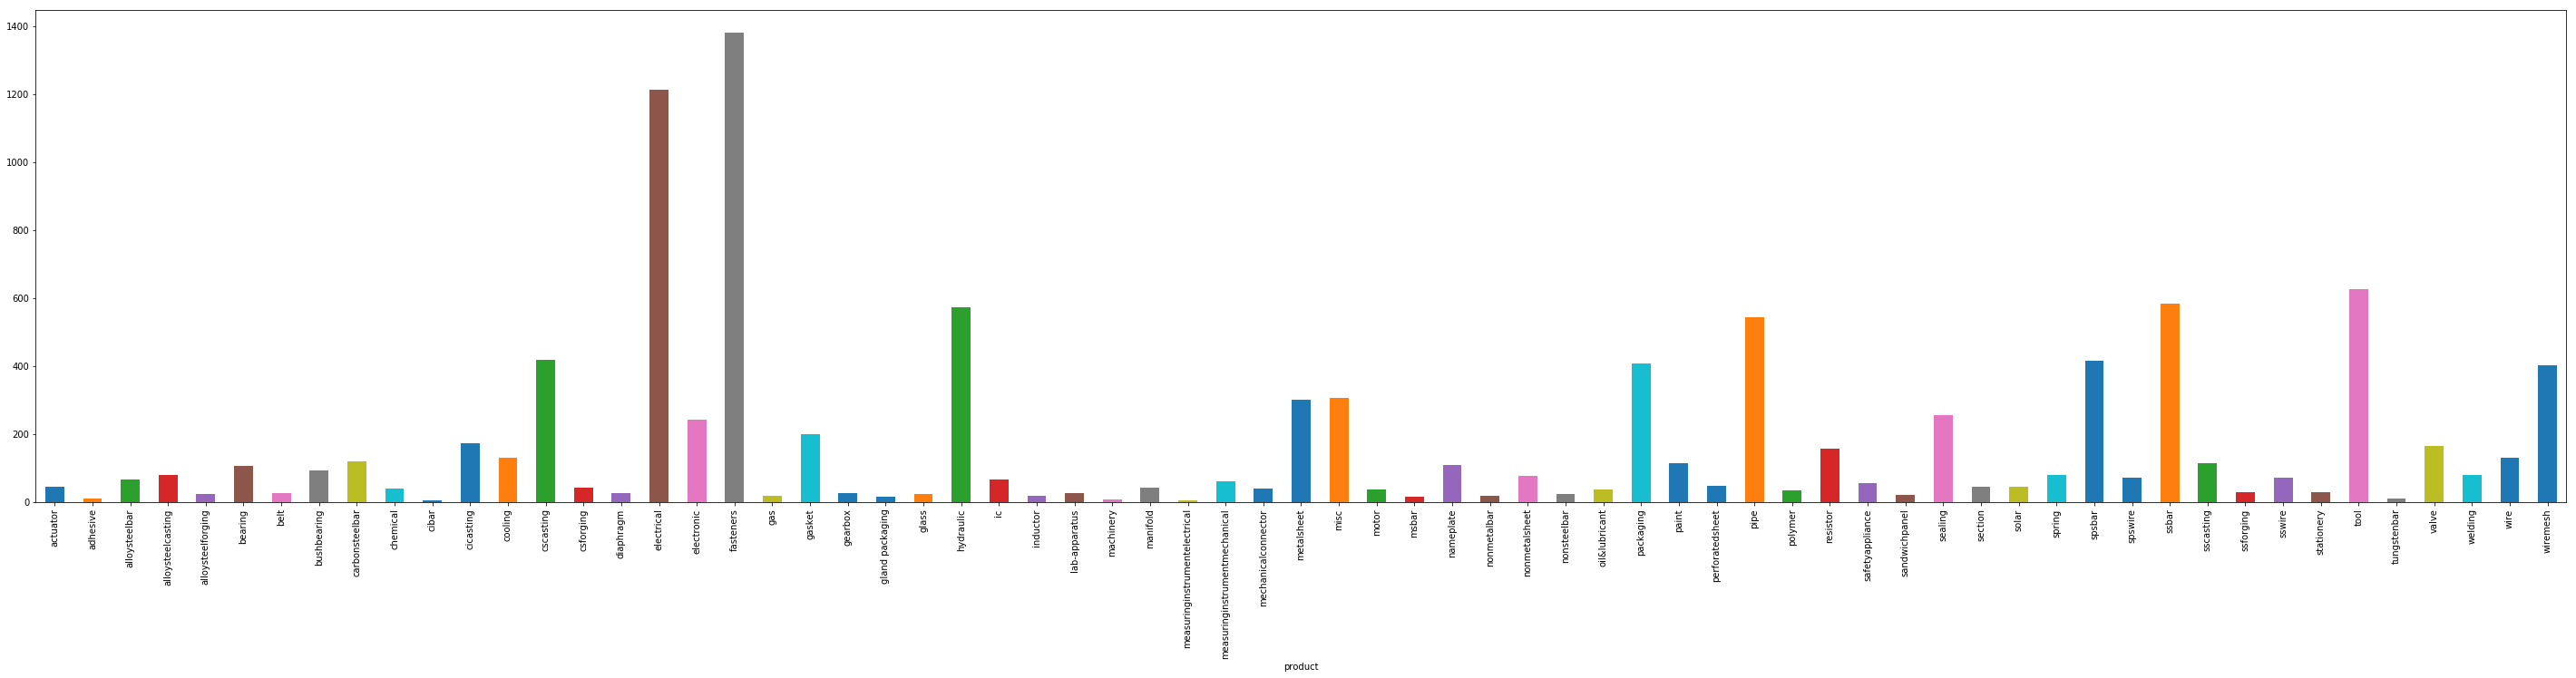

In [42]:
## To show distribution of product category

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(50,10))
print(max(tranzact_data_labelled.groupby('product').item.count()))
tranzact_data_labelled.groupby('product').item.count().plot.bar(ylim=0)
plt.show()

## Pl. note the unbalance distribution of product categories. In category Fasteners, there are 1736 items(maxm no.)

In [45]:
## Gives the product wise item distribution. In some product categories there are only 1 item.
from collections import Counter
Counter(tranzact_data_labelled["product"])

Counter({'actuator': 47,
         'adhesive': 12,
         'alloysteelbar': 66,
         'alloysteelcasting': 81,
         'alloysteelforging': 25,
         'bearing': 108,
         'belt': 28,
         'bushbearing': 93,
         'carbonsteelbar': 120,
         'chemical': 41,
         'cibar': 5,
         'cicasting': 173,
         'cooling': 132,
         'cscasting': 418,
         'csforging': 44,
         'diaphragm': 28,
         'electrical': 1201,
         'electronic': 243,
         'fasteners': 1376,
         'gas': 20,
         'gasket': 200,
         'gearbox': 28,
         'gland packaging': 17,
         'glass': 24,
         'group1': 165,
         'hydraulic': 574,
         'ic': 76,
         'inductor': 19,
         'lab-apparatus': 28,
         'machinery': 9,
         'manifold': 44,
         'measuringinstrumentelectrical': 6,
         'measuringinstrumentmechanical': 63,
         'mechanicalconnector': 41,
         'metalsheet': 301,
         'misc': 305,
         '

In [46]:
## Creating X and y variables for training. X = Items or item 'feature'. y = 'product' or product category

X = []
for i in range(tranzact_data_labelled.shape[0]):
    X.append(tranzact_data_labelled.iloc[i][1])
y = np.array(tranzact_data_labelled["product"])

print(X[0])


new cylinder gas


In [47]:
#train test split in 80% / 20% ratio

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

print(X_train[1])
print(y_train[1])
print(type(X_train))
print(type(y_train))
print(y_train)

hex bolt ss
fasteners
<class 'list'>
<class 'numpy.ndarray'>
['mechanicalconnector' 'fasteners' 'electronic' ... 'fasteners'
 'metalsheet' 'tool']


In [48]:
## Creating the pipeline for learning which include vectorizing and training with 
## Support Vector Classifier with Linear Kernel :

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier


model = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,2))), \
                  ('tfidf', TfidfTransformer(norm='l2', use_idf=True)), \
                  ('clf', OneVsRestClassifier(LinearSVC(C=1 , class_weight = 'balanced')))])

In [47]:
my_vectorizer = TfidfVectorizer(norm='l2', ngram_range=(1, 2), use_idf = True)
train_digital = my_vectorizer.fit_transform(tranzact_data_labelled.item).toarray()
train_label = (tranzact_data_labelled['product'])
train_digital.shape
#model_new = Pipeline([('tfidf'), ('clf', OneVsRestClassifier(LinearSVC(class_weight = 'balanced')))])

(10876, 17030)

In [49]:
#model_new = SVC(class_weight = 'balanced')
X_train_new, X_test_new, y_train_new, y_test_new, indices_train, indices_test = train_test_split(train_digital, \
                                                                train_label, tranzact_data_labelled.index, test_size=0.20, random_state=0)
#model_new.fit(X_train_new, y_train_new)
#y_pred_new = model_new.predict(X_test_new)

#from sklearn.metrics import confusion_matrix, accuracy_score

#model_accuracy = accuracy_score(y_pred_new, y_test_new)

#print(model_accuracy)


In [50]:
from sklearn.model_selection import cross_val_score
models = [OneVsRestClassifier(LinearSVC(C=100 , class_weight = 'balanced'))]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for modl in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(modl, X_train_new, y_train_new, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [51]:
cv_df

,model_name,fold_idx,accuracy
0,Pipeline,0,0.947339
1,Pipeline,1,0.940137
2,Pipeline,2,0.953475
3,Pipeline,3,0.945023
4,Pipeline,4,0.943308


In [49]:
#fit model with training data

model.fit(X_train, y_train)

#evaluation on test data

pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score

model_accuracy = accuracy_score(pred, y_test)

print(model_accuracy)


0.9554227941176471


In [62]:
# Creating dataframe for checking actual label vs, predicted label :

pred_test_df = pd.DataFrame({'item': X_test, 'product': y_test.tolist(), 'prediction': pred.tolist()})

In [63]:

pred_test_unmatched = pred_test_df[pred_test_df['prediction'] != pred_test_df['product']]

In [64]:
pred_test_unmatched.to_excel(r'/home/scar3crow/Downloads/accu_check_2.xlsx')

In [62]:
# Prediction of unlabelled data :

X_unlabelled = []
for i in range(tranzact_data_unlabelled.shape[0]):
    X_unlabelled.append(tranzact_data_unlabelled.iloc[i][1])
    
predict_unlabelled = model.predict(X_unlabelled)

predict_unlabelled_df = pd.DataFrame({'item': X_unlabelled, 'prediction': predict_unlabelled.tolist()})


In [63]:
predict_unlabelled_df.to_excel(r'/home/scar3crow/Downloads/umlabelled_check.xlsx')

In [64]:
predict_unlabelled_df.tail()

,item,prediction
10368,polybag pp,electrical
10369,polybag pp,electrical
10370,handle nut htb a194 gr8,fasteners
10371,round bar astm a276 type,ssbar
10372,pp monobox st5,electrical


In [66]:
tranzact_data_unlabelled.tail()

,OEM,item,product,supplier,find_duplicate
10368,R-Tech Products & Packaging Pvt Ltd,polybag pp,NaN,glory pack industries,polybag 12x17 inch_ppglory pack industries
10369,R-Tech Products & Packaging Pvt Ltd,polybag pp,NaN,glory pack industries,polybag_10x15 inch_ppglory pack industries
10370,CESARE BONETTI INDIA PVT. LTD.,handle nut htb a194 gr8,NaN,shah brothers,"handle nut 1"" #600,htb,a194 gr8shah brothers"
10371,Entech Controls,round bar astm a276 type,NaN,alpesh metals,round bar od50 astm a276 type 431alpesh metals
10372,R-Tech Products & Packaging Pvt Ltd,pp monobox st5,NaN,shree arun packaging co. pvt. ltd.,pp_monobox_st5shree arun packaging co. pvt. ltd.


In [76]:
## Input Item name here in the syntax given below :

Input_Item_Name = ['valve body casting']

In [77]:
## Find product category here :
Output_Product_Category = model.predict(Input_Item_Name)
print('Product Category = ', Output_Product_Category)
output_cat_list = Output_Product_Category.tolist()


Product Category =  ['group1']


In [120]:
## Saving the learned model :
from sklearn.externals import joblib

filename = 'svm_model_19_4_19.sav'
joblib.dump(model, filename)


['svm_model_19_4_19.sav']

In [ ]:
# load the model from disk
loaded_model = joblib.load(svm_model)

In [68]:
## creating data search file of all items of same category :

tranzact_data_search = tranzact_data_labelled.loc[tranzact_data_labelled['product'] \
                                                               == output_cat_list[0]]


tranzact_data_search = tranzact_data_search.reset_index(drop=True)
print(len(tranzact_data_search))
tranzact_data_search.head()

173


,OEM,item,product,supplier,find_duplicate,product_id
0,Truefit Engineering Company Limited,rm snh top ci casting grade fg260 is210,cicasting,s.m. industries,rm snh 616 top ( c.i. casting grade: fg 260 - ...,14
1,Truefit Engineering Company Limited,rm snh bottom ci casting grade fg260 is210,cicasting,s.m. industries,rm snh 616 bottom ( c.i. casting grade: fg 260...,14
2,Truefit Engineering Company Limited,rm sn518 top ci casting grade fg150 is210,cicasting,s.m. industries,rm sn 518 top ( c.i. casting grade: fg 150 - i...,14
3,Truefit Engineering Company Limited,rm sn517 bottom ci casting grade fg150 is210,cicasting,s.m. industries,rm sn 517 bottom ( c.i. casting grade: fg 150 ...,14
4,Truefit Engineering Company Limited,rm ts ci casting fg260 is210,cicasting,s.m. industries,rm ts 526 ((c.i. casting fg 260 - is 210-1993)...,14


In [69]:

from sklearn.feature_extraction.text import TfidfVectorizer

my_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', ngram_range=(1, 2), use_idf = True)
#digital_features = my_vectorizer.fit(tranzact_data_search['feature'])
#my_vector = digital_features.transform(tranzact_data_search['feature']).toarray()


## Creating test vector from Text features :

merge_text_feature = []
merge_text_feature_digit = []
merge_digit_vector = []
test_digit_vector = []

merge_text_feature = tranzact_data_search['item'].append(pd.Series(Input_Item_Name))

merge_text_feature = merge_text_feature.reset_index(drop=True)

merge_text_feature_digit = my_vectorizer.fit(merge_text_feature)

# encode document
merge_digit_vector = merge_text_feature_digit.transform(merge_text_feature).toarray()


test_digit_vector = merge_digit_vector[len(merge_digit_vector)-1].reshape((merge_digit_vector.shape)[1],)

merge_digit_vector_1 = merge_digit_vector[0:(len(merge_digit_vector)-1)]

print(merge_digit_vector_1.shape)
print(test_digit_vector.shape)



(173, 378)
(378,)


In [30]:
print(type(merge_text_feature))

<class 'pandas.core.series.Series'>


In [70]:
## Cosine Similarity :

def cos_cdist(matrix, vector):
    v = vector.reshape(1, -1)
    return scipy.spatial.distance.cdist(matrix, v, 'cosine').reshape(-1)

## Finding cosine similarity & picking 50 top similar lines :

c_d = []

c_d = np.round((1 - cos_cdist(merge_digit_vector_1, test_digit_vector)), 3)

max_c_s_index = []
max_c_s_index = np.argsort(c_d)[-50:][::-1]
print(max_c_s_index)

[163 172 170 169 168 171 153 165 157 166 167 160 156 162 159 164 161 155
 154 158 124  41  59  60 125 107  78  79 108 102  40 101  16  17   4  65
  89  84  85  12  87  88  28  91  96  97  99  11 100  90]


In [71]:
result = []
result_frame = []
max_c_s_index = []
max_c_s_index = np.argsort(c_d)[-50:][::-1]

for i in max_c_s_index:
    
    result.append(np.array([c_d[i], tranzact_data_search['item'][i], tranzact_data_search['supplier'][i]]))

result_frame = pd.DataFrame(result, columns=['c_index', 'item', 'supplier'])

result_frame.c_index = result_frame.c_index.astype('float64')

result_frame.drop_duplicates(subset='supplier', keep = 'first', inplace = True)
result_frame = result_frame.reset_index(drop=True)

kount = 0

for i in range(len(result_frame['supplier'])):
    if result_frame['c_index'][i] >= 0.10:
        print(result_frame['supplier'][i])
        kount = kount+1
        if kount == 5 :
            break
result_frame.head(10)

jay metal tech
tulip casting pvt. ltd.
bhagwati casters pvt. ltd.
jsons foundry pvt. ltd.
jagdish precision cast pvt. ltd.


,c_index,item,supplier
0,0.270,yoke casting km40,jay metal tech
1,0.195,yoke casting astm a536 a00004767,tulip casting pvt. ltd.
2,0.175,yoke casting r550 ci a00003729,bhagwati casters pvt. ltd.
3,0.162,yoke casting ra100 astm a536 a00004742,jsons foundry pvt. ltd.
4,0.149,multi spring yoke casting s g iron a00001224,jagdish precision cast pvt. ltd.
5,0.016,rm sofn top ci casting fg260 is210,goldlink technocast
6,0.016,rm sofn bottom ci casting fg260 is210,s.m. industries
7,0.016,rm sofn top ci casting fg260 is210,dhareshwar foundry
8,0.014,rm ts ci casting fg260 is210,local market delhi
9,0.013,rm snl top ci casting fg260 is210,ajjri metallics pvt ltd


In [193]:
merge_text_feature = []
merge_digit_vector = []
test_digit_vector = []

merge_text_feature = tranzact_data_search['feature'].append(pd.Series(Input_Item_Name))

merge_text_feature = merge_text_feature.reset_index(drop=True)

max_length_merge = max([len(s.split()) for s in merge_text_feature])

In [194]:
print(max_length_merge)
merge_text_feature.head()

30


0                  cable tie inch
1    way bar graph red face greay
2             led bar red lb714sr
3              batteries eveready
4               battery cr2032 3v
dtype: object

In [195]:
from gensim.models import Word2Vec

from tqdm import tqdm

merge_text_feature = []
merge_digit_vector = []
test_digit_vector = []

merge_text_feature = tranzact_data_search['feature'].append(pd.Series(Input_Item_Name))

merge_text_feature = merge_text_feature.reset_index(drop=True)

temp_corpus = merge_text_feature.map(lambda x: x.split('.'))

corpus = []
for i in tqdm(range(len(temp_corpus))):
    for line in temp_corpus[i]:
        words = [x for x in line.split()]
        corpus.append(words)

100%|██████████| 1258/1258 [00:00<00:00, 52876.44it/s]


In [91]:
print(len(corpus[0]))

3


In [196]:
## items to word2vec :

emb_dim = 100

model_1 = Word2Vec(corpus, size = emb_dim, window=2, \
               min_count=1, negative = 15, iter = 15, workers = 10, sg=1)

vocab_size = len(model_1.wv.vocab)

print(vocab_size)

print(model_1)

1711
Word2Vec(vocab=1711, size=100, alpha=0.025)


In [197]:
from keras.preprocessing.text import Tokenizer

tokenizer_merge = Tokenizer()
tokenizer_merge.fit_on_texts(merge_text_feature)

max_length_merge = max([len(s.split()) for s in merge_text_feature])
                        
tokenizer_merge_index = tokenizer_merge.word_index

vocab_size_merge = len(tokenizer_merge_index)
print(tokenizer_merge_index)                        

{'sod523': 1047, 'graph': 673, 'fanuc': 682, 'mmx4core': 1209, 'tpwcapacitor': 849, 'coolig': 1194, 'marker': 291, 'id6mm': 602, 'bus': 1684, 'b48': 1244, 'p1212': 633, '45w': 1606, '2h': 1259, 'running': 499, 'adapter': 638, 'mic': 956, 'ul': 1580, '5mtr': 635, 'miscellaneous': 1498, 'bss138': 1331, '14s': 896, '12pf': 495, 'battery': 106, 'qevmetalwork': 41, 'systems': 594, '57a': 385, 'double': 723, 'florex': 1077, '1uf': 77, 'schneider': 195, 'al': 1242, '10ma': 743, 'shavison': 1436, 'id8mm': 603, 'cuttoff': 648, '600vac': 1338, 'mfs201': 1414, 'wago': 889, 'vj1206y102jxaac': 786, 'class': 360, 'current': 200, 'tantalum': 361, '1p': 1308, 'leaded': 93, 'electronic': 713, 'c840': 1263, '1kv': 182, 'sugar': 1150, 'three': 436, '25lg': 1393, 'sw': 519, '500w': 1442, 'core': 10, 'tracer': 350, 'cordtpw': 1346, 'zerocrossover5mmal': 1341, '2e': 585, 'copper': 22, 'epcos': 305, 'p2as2e3p': 1528, '10a': 227, 'to247ac': 1328, 'rv6': 1273, 'efd15h': 1106, 'sb': 1051, 'main': 378, 'do214ac2

In [134]:
print(vocab_size_merge)
print(len(merge_text_feature))
print(corpus[0][2])
print(model_1.wv.get_vector(corpus[0][0]))

1708
1258
inch
[ 0.00531422 -0.08740324 -0.08222257 -0.12899801 -0.15475085 -0.163057
  0.18513985 -0.36062765 -0.32775584 -0.04065453  0.3184027   0.3695678
 -0.5101895   0.03564022 -0.08278285  0.37450826 -0.12547307  0.20521249
 -0.12950574 -0.23542361 -0.04343544  0.18400235  0.02711576  0.15075897
 -0.03023637  0.42508173  0.351758   -0.11873965 -0.10947298 -0.15610208
 -0.43448284 -0.17689821 -0.2501244  -0.03748987 -0.06745612  0.10779626
  0.21494459  0.06624966  0.25569037 -0.11911091 -0.1880119   0.24927732
  0.08494496  0.05017168  0.10188263  0.11363015  0.07888637  0.11526236
 -0.27141827 -0.18781136  0.13344045 -0.01295647 -0.00898362  0.20055954
  0.01691925  0.06470533 -0.23988712  0.13110223 -0.05131466 -0.26941225
 -0.00082231  0.28596535 -0.07595673 -0.23382907 -0.08251759  0.05898278
 -0.31087568 -0.2450818   0.31771743  0.01451331 -0.06168523  0.11082708
  0.09837241 -0.03204493  0.2410294 ]


In [198]:
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
a = [1, 2, 3, 4, 5]
b = np.pad(a, (0,3), 'constant', constant_values=0)
print(b)
print(len(corpus[1]))

[1 2 3 4 5 0 0 0]
6


In [199]:
## Prepare matrix for co-sine similarity:

size_col = max_length_merge * emb_dim

embedding_matrix = np.zeros((len(merge_text_feature), emb_dim))

for i in range(len(merge_text_feature)):
    
    emb_mat = np.zeros((1, emb_dim*len(corpus[i])))
    emb_mat_col = emb_dim*len(corpus[i])
    
    emb_vector = np.zeros((len(corpus[i]), emb_dim))
    for j in range(len(corpus[i])):
        emb_vector[j] = model_1.wv.get_vector(corpus[i][j])
    
      
#    emb_mat = emb_vector.ravel()
    

#    embedding_matrix[i] = np.pad(emb_mat, (0, (size_col - emb_mat_col)), 'constant', constant_values = 0)
        
    embedding_matrix[i] = np.max(emb_vector, axis = 0)
    


        
print(embedding_matrix.shape)
        
#print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))


(1258, 100)


In [125]:
print(embedding_matrix[0])

[ 0.03776038 -0.05264485 -0.09356659 ...  0.          0.
  0.        ]


In [200]:
test_digit_vector = embedding_matrix[len(embedding_matrix)-1].reshape((embedding_matrix.shape)[1],)

merge_digit_vector_1 = embedding_matrix[0:(len(embedding_matrix)-1)]

print(merge_digit_vector_1.shape)
print(test_digit_vector.shape)


(1257, 100)
(100,)


In [201]:
c_d = []

c_d = np.round((1 - cos_cdist(merge_digit_vector_1, test_digit_vector)), 3)

max_c_s_index = []
max_c_s_index = np.argsort(c_d)[-50:][::-1]

result = []
result_frame = []
max_c_s_index = []
max_c_s_index = np.argsort(c_d)[-50:][::-1]

for i in max_c_s_index:
    
    result.append(np.array([c_d[i], tranzact_data_search['feature'][i], tranzact_data_search['supplier'][i]]))

result_frame = pd.DataFrame(result, columns=['c_index', 'feature', 'supplier'])

result_frame.c_index = result_frame.c_index.astype('float64')

result_frame.drop_duplicates(subset='supplier', keep = 'first', inplace = True)
result_frame = result_frame.reset_index(drop=True)

kount = 0

for i in range(len(result_frame['supplier'])):
    if result_frame['c_index'][i] >= 0.10:
        print(result_frame['supplier'][i])
        kount = kount+1
        if kount == 5 :
            break
result_frame.head(10)

DAMODAR ENTERPRISES
Ankit Marketing Pvt. Ltd.
M/S. S. K. Enterprise
IDEAL RESOURCES PRODUTCS PVT. LTD.
A.M Steel Traders


,c_index,feature,supplier
0,1.000,solder iron 35w soldering bit,DAMODAR ENTERPRISES
1,1.000,solder iron 35w,Ankit Marketing Pvt. Ltd.
2,0.999,bottom insulator gv3,M/S. S. K. Enterprise
3,0.999,meanwell 24v smps rs2524,IDEAL RESOURCES PRODUTCS PVT. LTD.
4,0.999,chk coil 3uh 5a,A.M Steel Traders
5,0.999,resistor 100k,CESARE BONETTI INDIA PVT. LTD.
6,0.999,pin plug top 5a anchor,NEHA ENTERPRISES
7,0.999,speed regulator,PANTH ENTERPRISES
8,0.999,stator gv3,WAAREE INDUSTRIES PVT. LTD.
9,0.999,contactor 3tf31,Nemi Electricals
